In [1]:
import eli5
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tqdm
import re
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron
from math import sqrt
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import torch

F:\Desktop\Classes\cs4120-hw4\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing

In [2]:
dataset = pd.read_csv('data/train.tsv', sep='\t', header=0)
dataset['category_name'] = dataset['category_name'].fillna('Other').astype(str)
dataset['brand_name'] = dataset['brand_name'].fillna('missing').astype(str)
dataset['shipping'] = dataset['shipping']
dataset['item_condition_id'] = dataset['item_condition_id']
dataset['item_description'] = dataset['item_description'].fillna('None')

In [3]:
dataset = dataset[dataset.price>0] # Remove entries with negative price

In [4]:
# split category into general, sub1, and sub2
categories = list(dataset['category_name'])

gencat_list = []
subcat1_list = []
subcat2_list = []

for cat in categories:
    cats = cat.split("/")
    cats[0] = cats[0].replace(' ','')
    cats[0] = cats[0].replace('&','_')
    if len(cats) > 1: 
        cats[1] = cats[1].replace(' ','')
        cats[1] = cats[1].replace('&','_')
    if len(cats) > 2: 
        cats[2] = cats[2].replace(' ','')
        cats[2] = cats[2].replace('&','_')
    gencat_list.append(cats[0].strip())
    subcat1_list.append(cats[1].strip() if len(cats) > 1 else "Other")
    subcat2_list.append(cats[2].strip() if len(cats) > 2 else "Other")

dataset["general_category"] = gencat_list
dataset["subcategory_1"] = subcat1_list
dataset["subcategory_2"] = subcat2_list
dataset.drop('category_name', axis=1, inplace=True)

In [5]:
X = dataset.loc[:, dataset.columns != 'price']
Y = np.log1p(dataset['price'])

# 80% training data, 20% test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [6]:
# one hot encode categorical features that are not already numbers

def one_hot_categorical(train, test):
    vectorizer = CountVectorizer(lowercase=False, binary=True)
    onehot_train = vectorizer.fit_transform(train.values)
    onehot_test = vectorizer.transform(test.values)
    return onehot_train, onehot_test

onehot_train_brand, onehot_test_brand = one_hot_categorical(X_train['brand_name'], X_test['brand_name'])
onehot_train_gencat, onehot_test_gencat = one_hot_categorical(X_train['general_category'], X_test['general_category'])
onehot_train_subcat1, onehot_test_subcat1 = one_hot_categorical(X_train['subcategory_1'], X_test['subcategory_1'])
onehot_train_subcat2, onehot_test_subcat2 = one_hot_categorical(X_train['subcategory_2'], X_test['subcategory_2'])

In [7]:
# Use tfidf for text-based features

def tfidf_text(train, test, min_df, max_features):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=min_df, max_features=max_features)
    tfidf_train = vectorizer.fit_transform(train.values)
    tfidf_test = vectorizer.transform(test.values)
    return tfidf_train, tfidf_test
    
tfidf_train_name, tfidf_test_name = tfidf_text(X_train['name'], X_test['name'], 3, 250000)
tfidf_train_description, tfidf_test_description = tfidf_text(X_train['item_description'], X_test['item_description'], 5, 500000)

In [8]:
# Storing categorical features that are already numbers to sparse matrix

X_train_cat = csr_matrix(pd.get_dummies(X_train[['item_condition_id', 'shipping']], sparse=True).values)

X_test_cat = csr_matrix(pd.get_dummies(X_test[['item_condition_id', 'shipping']], sparse=True).values)

In [9]:
print(X_train_cat.shape, X_test_cat.shape)

(1185328, 2) (296333, 2)


In [10]:
# stack all categorical and text sparse matrices
train_x = hstack((onehot_train_brand, onehot_train_gencat, onehot_train_subcat1, onehot_train_subcat2, 
                       tfidf_train_name, tfidf_train_description, X_train_cat)).tocsr()
test_x = hstack((onehot_test_brand, onehot_test_gencat, onehot_test_subcat1, onehot_test_subcat2, 
                       tfidf_test_name, tfidf_test_description, X_test_cat)).tocsr()

In [11]:
print(train_x.shape, test_x.shape)

(1185328, 755935) (296333, 755935)


### Ridge Regression

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]F:\Desktop\Classes\cs4120-hw4\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:830: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
 11%|█████████▏                                                                         | 1/9 [02:23<19:11, 143.92s/it]F:\Desktop\Classes\cs4120-hw4\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:830: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(
 22%|██████████████████▍                                                                | 2/9 [03:

RMSLE for alpha =  1 is 0.443143070567117
RMSLE for alpha =  2 is 0.43805985358439264
RMSLE for alpha =  3 is 0.437508664007679
RMSLE for alpha =  3.5 is 0.4377504452105116
RMSLE for alpha =  4 is 0.43815227171846255
RMSLE for alpha =  4.5 is 0.4386530251699621
RMSLE for alpha =  5 is 0.4392109054475655
RMSLE for alpha =  6 is 0.44041454744644054
RMSLE for alpha =  7 is 0.44165225658510726


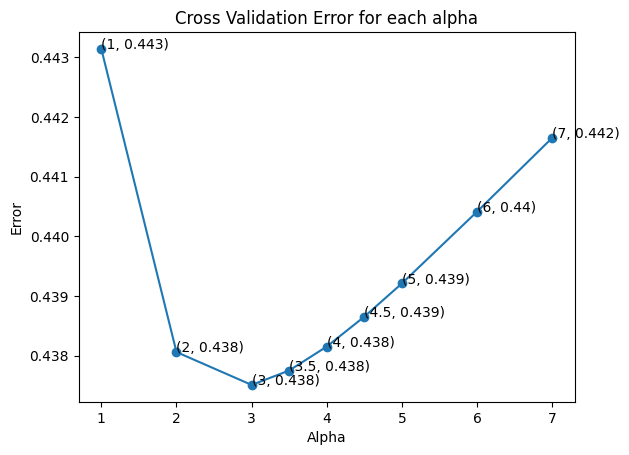

In [12]:
alpha = [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7] 
test_rmsle_array=[] 
for i in tqdm.tqdm(alpha):
    model = Ridge(solver="sag", random_state=42, alpha=i)
    model.fit(train_x, Y_train)
    preds_test = model.predict(test_x)
    test_rmsle_array.append(sqrt(mse(Y_test, preds_test)))

for i in range(len(test_rmsle_array)):
    print ('RMSLE for alpha = ',alpha[i],'is',test_rmsle_array[i])
    
best_alpha = np.argmin(test_rmsle_array)

fig, ax = plt.subplots()
ax.plot(alpha, test_rmsle_array)
ax.scatter(alpha, test_rmsle_array)
for i, txt in enumerate(np.round(test_rmsle_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],test_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [100]:
print("Best alpha: ",  alpha[best_alpha])
model = Ridge(solver="sag", random_state=42, alpha=alpha[best_alpha])
model.fit(train_x, Y_train)
ridge_preds_train = model.predict(train_x)
ridge_preds_test = model.predict(test_x)

print('Train RMSLE:', sqrt(mse(Y_train, ridge_preds_train)))
print("Test RMSLE: ", sqrt(mse(Y_test, ridge_preds_test)))

Best alpha:  3


F:\Desktop\Classes\cs4120-hw4\.venv\lib\site-packages\sklearn\linear_model\_ridge.py:830: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


Train RMSLE: 0.37399684032095765
Test RMSLE:  0.437508664007679


### SGD Regressor

In [101]:
# SGD Regressor

model = SGDRegressor(random_state=42)
model.fit(train_x, Y_train)
sgd_preds_train = model.predict(train_x)
sgd_preds_test = model.predict(test_x)

print('Train RMSLE:', sqrt(mse(Y_train, sgd_preds_train)))
print("Test RMSLE: ", sqrt(mse(Y_test, sgd_preds_test)))

Train RMSLE: 0.5110285276940384
Test RMSLE:  0.5145698683588359


In [44]:
from typing import List, Tuple, Union
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import Linear, ReLU
import math

class DNN(nn.Module):
    def __init__(self, layer_sizes: List[int]):
        """
        The first layer size is the input dimension, and the last layer size is the output dimension.
        :param layer_sizes:
        """
        super(DNN, self).__init__()

        self.layers = nn.ModuleList()

        for i in range(0, len(layer_sizes) - 1):
            self.layers.append(Linear(in_features=layer_sizes[i],
                                      out_features=layer_sizes[i + 1]))
            self.layers.append(ReLU())

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            # print(f'Layer {layer} with input size {x.size()}')
            x = layer(x)
        return x

In [175]:
class SparseDataset(Dataset):
    """
    Custom Dataset class for scipy sparse matrix
    """

    def __init__(self, x, y):
        # Transform data coo_matrix to csr_matrix for indexing
        # if type(data) == coo_matrix:
        #     self.data = data.tocsr()
        # else:
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]
        # Transform targets coo_matrix to csr_matrix for indexing
        # if type(targets) == coo_matrix:
        #     self.targets = targets.tocsr()
        # else:

    def __getitem__(self, index: int):
        # return self.data[index], self.targets[index]
#         x = self.data.getrow(index) if self.datatype == csr_matrix else self.data[index]
#         y = self.targets.getrow(index) if self.targettype == csr_matrix else self.targets[index]
#         return x, y
        return self.x[index], self.y[index]

    def __len__(self):
#         return self.data.shape[0]
        return self.length

In [176]:
def train_model(model, train: Tuple[csr_matrix, np.ndarray], test: Tuple[csr_matrix, np.ndarray], 
                batch_size: int, epochs: int):
    train_dataloader = DataLoader(SparseDataset(train[0], train[1]), batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(SparseDataset(test[0], test[1]), batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters())
    
    for j in range(epochs):
        display = tqdm.trange(epochs)
        train_losses = []
        test_losses = []
        running_loss = 0.0
        for i, (x_train,y_train) in enumerate(train_dataloader):
            y_pred = model(x_train)
            
            _,predicted = torch.max(y_pred.data, 1)
            
            loss = nn.MSELoss()(y_pred,y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss/len(train_dataloader))
        
        running_loss = 0
        with torch.no_grad():
            for i, (x_train,y_train) in enumerate(test_dataloader):
                y_pred = model(x_train)
                _,predicted = torch.max(y_pred.data, 1)
                
                loss = nn.MSELoss()(y_pred,y_train)
                running_loss += loss.item()
        
            test_losses.append(running_loss/len(test_dataloader))
        display.set_description(f'Test loss: {running_loss/len(test_dataloader):.5}')
    return train_losses, test_losses

def evaluate_model(model, dataset: Tuple[csr_matrix, np.ndarray]) -> float:
    X, Y = dataset
    X_tens, Y_tens = torch.as_tensor(X.todense(), dtype=torch.float32), torch.as_tensor(Y, dtype=torch.float32)

    with torch.no_grad():
        raw_pred = model(X_tens)
        predictions = np.array(torch.argmax(raw_pred, dim=1))

    loss = torch.nn.MSELoss()(predictions, Y_tens)
    return loss.item()

### MLP Regressor

In [12]:
from sklearn.neural_network import MLPRegressor

In [112]:
%%time
# Using only 10000 samples due to computation time

mlp = MLPRegressor(hidden_layer_sizes=(64,64,64), activation="relu", random_state=1, max_iter=200, verbose=True)

mlp.fit(train_x[:10000],Y_train[:10000])

mlp_preds_train = mlp.predict(train_x)
mlp_preds_test = mlp.predict(test_x)

print('Train RMSLE:', sqrt(mse(Y_train, mlp_preds_train)))
print("Test RMSLE: ", sqrt(mse(Y_test, mlp_preds_test)))

<timed exec>:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


Iteration 1, loss = 1.25257955
Iteration 2, loss = 0.18665923
Iteration 3, loss = 0.08466603
Iteration 4, loss = 0.03728112
Iteration 5, loss = 0.01772042
Iteration 6, loss = 0.01116509
Iteration 7, loss = 0.00963622
Iteration 8, loss = 0.00910508
Iteration 9, loss = 0.00898429
Iteration 10, loss = 0.00842647
Iteration 11, loss = 0.00800352
Iteration 12, loss = 0.00699192
Iteration 13, loss = 0.00644599
Iteration 14, loss = 0.00591140
Iteration 15, loss = 0.00540948
Iteration 16, loss = 0.00504242
Iteration 17, loss = 0.00468713
Iteration 18, loss = 0.00447729
Iteration 19, loss = 0.00426287
Iteration 20, loss = 0.00404494
Iteration 21, loss = 0.00392797
Iteration 22, loss = 0.00387956
Iteration 23, loss = 0.00385108
Iteration 24, loss = 0.00372794
Iteration 25, loss = 0.00375177
Iteration 26, loss = 0.00368067
Iteration 27, loss = 0.00346473
Iteration 28, loss = 0.00334771
Iteration 29, loss = 0.00309430
Iteration 30, loss = 0.00291876
Iteration 31, loss = 0.00283305
Iteration 32, los

In [108]:
%%time
# Using 100000 samples with batch size of 10000 due to computation time

mlp = MLPRegressor(hidden_layer_sizes=(64,64,64), activation="relu", batch_size=10000, random_state=1, max_iter=200, verbose=True)

mlp.fit(train_x[:100000],Y_train[:100000])

mlp_preds_train = mlp.predict(train_x)
mlp_preds_test = mlp.predict(test_x)

print('Train RMSLE:', sqrt(mse(Y_train, mlp_preds_train)))
print("Test RMSLE: ", sqrt(mse(Y_test, mlp_preds_test)))

<timed exec>:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


Iteration 1, loss = 3.23628260
Iteration 2, loss = 1.37516803
Iteration 3, loss = 0.40521143
Iteration 4, loss = 0.30906251
Iteration 5, loss = 0.22056364
Iteration 6, loss = 0.16257909
Iteration 7, loss = 0.13316035
Iteration 8, loss = 0.10974396
Iteration 9, loss = 0.09092444
Iteration 10, loss = 0.07576246
Iteration 11, loss = 0.06335074
Iteration 12, loss = 0.05272056
Iteration 13, loss = 0.04390189
Iteration 14, loss = 0.03640429
Iteration 15, loss = 0.02976699
Iteration 16, loss = 0.02392872
Iteration 17, loss = 0.01895557
Iteration 18, loss = 0.01496367
Iteration 19, loss = 0.01188738
Iteration 20, loss = 0.00952448
Iteration 21, loss = 0.00776971
Iteration 22, loss = 0.00645420
Iteration 23, loss = 0.00543322
Iteration 24, loss = 0.00466833
Iteration 25, loss = 0.00408526
Iteration 26, loss = 0.00362376
Iteration 27, loss = 0.00325250
Iteration 28, loss = 0.00295199
Iteration 29, loss = 0.00270862
Iteration 30, loss = 0.00252408
Iteration 31, loss = 0.00236268
Iteration 32, los

In [113]:
%%time
# Using all samples with batch size of 50000 due to computation time

mlp = MLPRegressor(hidden_layer_sizes=(64,64,64), activation="relu", batch_size=50000, random_state=1, max_iter=200, verbose=True)

mlp.fit(train_x,Y_train)

mlp_preds_train = mlp.predict(train_x)
mlp_preds_test = mlp.predict(test_x)

print('Train RMSLE:', sqrt(mse(Y_train, mlp_preds_train)))
print("Test RMSLE: ", sqrt(mse(Y_test, mlp_preds_test)))

Iteration 1, loss = 1.96490346
Iteration 2, loss = 0.31538129
Iteration 3, loss = 0.16724672
Iteration 4, loss = 0.12584707
Iteration 5, loss = 0.10440702
Iteration 6, loss = 0.09105322
Iteration 7, loss = 0.08091964
Iteration 8, loss = 0.07184150
Iteration 9, loss = 0.06470138
Iteration 10, loss = 0.05938845
Iteration 11, loss = 0.05536580
Iteration 12, loss = 0.05211436
Iteration 13, loss = 0.04930886
Iteration 14, loss = 0.04680511
Iteration 15, loss = 0.04446855
Iteration 16, loss = 0.04226577
Iteration 17, loss = 0.04016985
Iteration 18, loss = 0.03812141
Iteration 19, loss = 0.03614195
Iteration 20, loss = 0.03424658
Iteration 21, loss = 0.03240474
Iteration 22, loss = 0.03065859
Iteration 23, loss = 0.02898709
Iteration 24, loss = 0.02743660
Iteration 25, loss = 0.02599316
Iteration 26, loss = 0.02456834
Iteration 27, loss = 0.02326330
Iteration 28, loss = 0.02208562
Iteration 29, loss = 0.02096315
Iteration 30, loss = 0.01996658
Iteration 31, loss = 0.01900421
Iteration 32, los

Citations:

https://towardsdatascience.com/mercari-price-suggestion-97ff15840dbd